Let's start by improting all necessary libraries.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


print('Libraries imported.')



Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In order to use Foursquare API, we need to input our credentials

In [46]:
# The code was removed by Watson Studio for sharing.

And now we can upload both of our San Francisco datasets. Let's start by gathering registered businesses in the Bay Area.

### Registered Business Data

In [3]:
business = pd.read_csv('https://data.sfgov.org/api/views/g8m3-pdis/rows.csv?accessType=DOWNLOAD')
print(business.shape)
business.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (12,13,14,15,21,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(250406, 26)


Location Id  Business Account Number     Ownership Name  \
0  1103593-08-161                  1049564  Anjan Rajbhandari   
1  1218784-04-191                  1100756      Luisa Alberto   
2  1223199-05-191                  1102424       Sunrun, Inc.   
3  1220748-05-191                  1101579    Felix Hernandez   
4  1135452-02-171                  1065102          Tirta Llc   

           DBA Name    Street Address           City State  Source Zipcode  \
0              Uber  28134 Harvey Ave        Hayward    CA         94544.0   
1      High Five Sf       467 14th St  San Francisco    CA         94103.0   
2       Sunrun, Inc     595 Market St  San Francisco    CA         94105.0   
3  Tru-Tec Electric      44 Mcaker Ct      San Mateo    CA         94403.0   
4             Tirta  105 Hudson St 6s  New York City    NY         10013.0   

  Business Start Date Business End Date Location Start Date Location End Date  \
0          03/24/2014        12/31/2017          03/24/2014        12/31/2017   
1          04/15/2019        04/15/2019          04/15/2019        04/15/2019   
2          06/01/2008        06/01/2008          06/01/2008        06/01/2008   
3          05/06/2019        06/18/2019          05/06/2019        06/18/2019   
4          06/09/2016        12/23/2018          06/09/2016        12/23/2018   

  Mail Address Mail City Mail Zipcode Mail State NAICS Code  \
0          NaN       NaN          NaN        NaN        NaN   
1          NaN       NaN          NaN        NaN        NaN   
2          NaN       NaN          NaN        NaN  2200-2299   
3          NaN       NaN          NaN        NaN        NaN   
4          NaN       NaN          NaN        NaN        NaN   

  NAICS Code Description  Parking Tax  Transient Occupancy Tax LIC Code  \
0                    NaN        False                    False      NaN   
1                    NaN        False                    False      NaN   
2              Utilities        False                    False      NaN   
3                    NaN        False                    False      NaN   
4                    NaN        False                    False      NaN   

  LIC Code Description  Supervisor District  \
0                  NaN                  NaN   
1                  NaN                  8.0   
2                  NaN                  NaN   
3                  NaN                  NaN   
4                  NaN                  NaN   

  Neighborhoods - Analysis Boundaries Business Corridor Business Location  
0                                 NaN               NaN               NaN  
1                             Mission               NaN               NaN  
2                                 NaN               NaN               NaN  
3                                 NaN               NaN               NaN  
4                                 NaN               NaN               NaN

In [4]:
#just pull the columns we need
business2 = business[['Business Start Date','DBA Name', 'Neighborhoods - Analysis Boundaries']].copy()

#drop null values
business3 = business2.dropna()

#convert business start date to datetime
business3['Business Start Date'] = business3['Business Start Date'].astype('datetime64[ns]') 

#let's just look at areas that have seen the most businesses start in the last decade.
business4 = business3.loc[business3['Business Start Date'] > '2010-01-01']

#let's also rename 'Neighborhoods - Analysis Boundaries' to just be 'Neighborhoods'
business4.rename(columns={'Neighborhoods - Analysis Boundaries': 'Neighborhood'}, inplace = True)

#let's do the same thing for the business name
business4.rename(columns={'DBA Name': 'Business Name'}, inplace = True)

business4.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Business Start Date     Business Name     Neighborhood
1            2019-04-15      High Five Sf          Mission
211          2015-01-01       Erhan Ersin       Tenderloin
234          2017-05-08       2100 Rivera  Sunset/Parkside
246          2012-03-27  Robert P Moseley   Outer Richmond
282          2012-05-01        Band Width       Tenderloin

In [5]:
#Count the number of businesses in each neighborhood by grouping the data
business5 = business4.groupby('Neighborhood', as_index=False).count()
business5.reset_index()
#let's get rid of the business start date, we won't be needing it anymore
business5.drop(columns = 'Business Start Date',inplace = True)
#rename our "business name" column to "Businesses" to reflect the count per neighborhood
business5.rename(columns={'Business Name': 'Businesses'}, inplace = True)
#and sort the data
business6 = business5.sort_values(by= ['Businesses'], ascending = False).head(10)
business6.reset_index(drop=True)
business6

Neighborhood  Businesses
5   Financial District/South Beach       11244
18                         Mission        6191
33                 South of Market        5282
34                 Sunset/Parkside        4077
0            Bayview Hunters Point        3341
25                  Outer Richmond        2736
16                          Marina        2530
2              Castro/Upper Market        2483
39              West of Twin Peaks        2354
9                     Hayes Valley        2351

In [6]:
#for reference, here is every neighborhood in SF as well as the count of registered businesses
business7 = business5.sort_values(by= ['Businesses'], ascending = False)
business7.reset_index(drop=True)
print(business7.shape)
business7

(41, 2)


Neighborhood  Businesses
5   Financial District/South Beach       11244
18                         Mission        6191
33                 South of Market        5282
34                 Sunset/Parkside        4077
0            Bayview Hunters Point        3341
25                  Outer Richmond        2736
16                          Marina        2530
2              Castro/Upper Market        2483
39              West of Twin Peaks        2354
9                     Hayes Valley        2351
20                        Nob Hill        2327
35                      Tenderloin        2251
28                    Potrero Hill        2144
3                        Chinatown        2143
26                 Pacific Heights        2135
1                   Bernal Heights        1990
21                      Noe Valley        1942
11                    Inner Sunset        1758
10                  Inner Richmond        1612
8                   Haight Ashbury        1597
40                Western Addition        1559
4                        Excelsior        1542
31                    Russian Hill        1538
22                     North Beach        1534
19                     Mission Bay        1349
23      Oceanview/Merced/Ingleside        1159
24                   Outer Mission        1103
15               Lone Mountain/USF        1014
30                Presidio Heights         967
27                         Portola         662
13                       Lakeshore         609
38               Visitacion Valley         599
6                        Glen Park         576
37                      Twin Peaks         404
12                       Japantown         395
29                        Presidio         341
36                 Treasure Island         256
32                        Seacliff         105
7                 Golden Gate Park          24
17                    McLaren Park          12
14                    Lincoln Park          11

excellent. now let's plot our data to get a good view

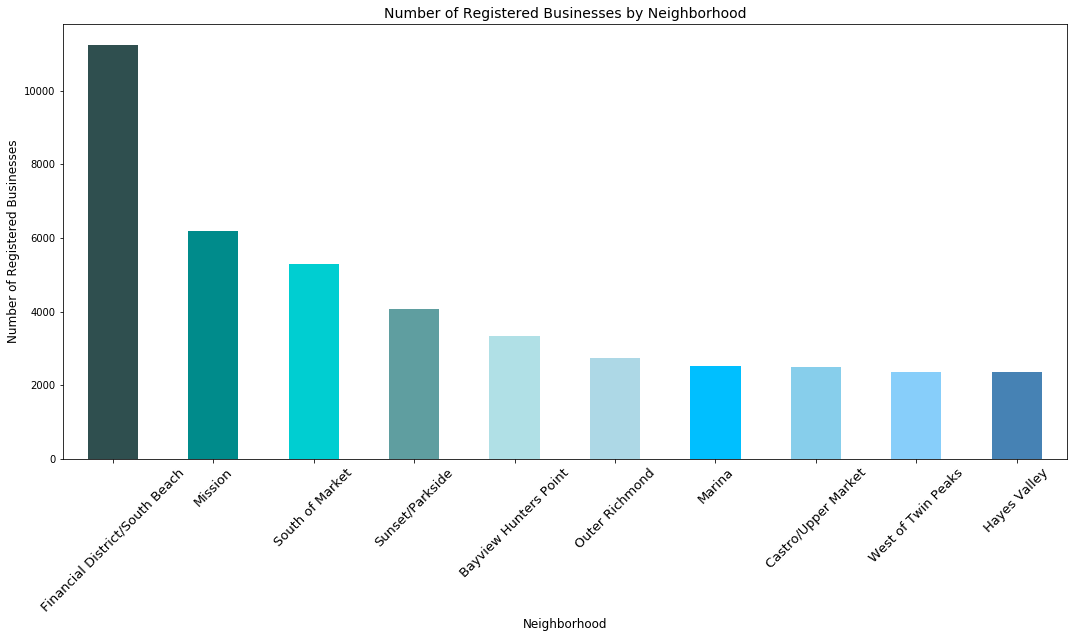

In [7]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt


business6.plot.bar(x = 'Neighborhood', y = 'Businesses', title = "Number of Registered Businesses by Neighborhood", legend = None, rot= 45, figsize = (18, 8), color=['darkslategray','darkcyan','darkturquoise','cadetblue', 'powderblue','lightblue','deepskyblue','skyblue','lightskyblue','steelblue'])
plt.ylabel('Number of Registered Businesses', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.title('Number of Registered Businesses by Neighborhood', fontsize = 14)
plt.show()


It looks like the Financial District has the most businesses, but there are plenty of others that have lots of people working! Let's use the top 10 neighborhoods as our starting point.

Next, we want to make sure our bar is in a safe part of town. So let's use San Francisco's crime data from the last 5 years to narrow down our list.

### Crime Data

In [8]:
crime = pd.read_csv('https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD')
print(crime.shape)
crime.head()

(294865, 35)


Incident Datetime Incident Date Incident Time  Incident Year  \
0  2019/08/15 11:41:00 AM    2019/08/15         11:41           2019   
1  2019/09/17 10:00:00 PM    2019/09/17         22:00           2019   
2  2019/10/04 02:25:00 PM    2019/10/04         14:25           2019   
3  2019/10/03 07:30:00 PM    2019/10/03         19:30           2019   
4  2019/10/04 04:53:00 PM    2019/10/04         16:53           2019   

  Incident Day of Week         Report Datetime       Row ID  Incident ID  \
0             Thursday  2019/10/01 02:06:00 PM  85424006374       854240   
1              Tuesday  2019/10/02 10:01:00 PM  85426606374       854266   
2               Friday  2019/10/04 04:13:00 PM  85442603474       854426   
3             Thursday  2019/10/03 11:25:00 PM  85419706244       854197   
4               Friday  2019/10/04 04:53:00 PM  85446351040       854463   

   Incident Number   CAD Number Report Type Code Report Type Description  \
0        196208089          NaN               II        Coplogic Initial   
1        196208205          NaN               II        Coplogic Initial   
2        190746203  192772728.0               II                 Initial   
3        190744514  192764437.0               II                 Initial   
4        190746532  192772932.0               II                 Initial   

  Filed Online  Incident Code Incident Category    Incident Subcategory  \
0         True           6374     Larceny Theft   Larceny Theft - Other   
1         True           6374     Larceny Theft   Larceny Theft - Other   
2          NaN           3474           Robbery         Robbery - Other   
3          NaN           6244     Larceny Theft  Larceny - From Vehicle   
4          NaN          51040      Non-Criminal            Non-Criminal   

                Incident Description      Resolution  \
0       Theft, Other Property, >$950  Open or Active   
1       Theft, Other Property, >$950  Open or Active   
2            Robbery, Att., W/ Force  Open or Active   
3  Theft, From Locked Vehicle, >$950  Open or Active   
4                         Aided Case  Open or Active   

                          Intersection         CNN Police District  \
0                                  NaN         NaN         Central   
1                                  NaN         NaN       Out of SF   
2                BALBOA ST \ GREAT HWY  28009000.0        Richmond   
3             MARKET ST \ RESERVOIR ST  25877000.0         Mission   
4  42ND AVE \ CLEMENT ST \ VETERANS DR  27919000.0        Richmond   

  Analysis Neighborhood  Supervisor District   Latitude   Longitude  \
0                   NaN                  NaN        NaN         NaN   
1                   NaN                  NaN        NaN         NaN   
2        Outer Richmond                  1.0  37.775076 -122.511295   
3   Castro/Upper Market                  8.0  37.768770 -122.427462   
4        Outer Richmond                  1.0  37.781177 -122.503086   

                                           point  SF Find Neighborhoods  \
0                                            NaN                    NaN   
1                                            NaN                    NaN   
2  POINT (-122.51129492624534 37.77507596005672)                    8.0   
3  POINT (-122.42746205880601 37.76877049785351)                   28.0   
4  POINT (-122.5030864538133 37.781176766186576)                    6.0   

   Current Police Districts  Current Supervisor Districts  \
0                       NaN                           NaN   
1                       NaN                           NaN   
2                       8.0                           4.0   
3                       3.0                           5.0   
4                       8.0                           4.0   

   Analysis Neighborhoods  HSOC Zones as of 2018-06-05  OWED Public Spaces  \
0                     NaN                          NaN                 NaN   
1                     NaN                          

In [9]:
#take just the columns we need
crime1 = crime[['Analysis Neighborhood','Incident Category', 'Incident Date']]

#drop all null values
crime2 = crime1.dropna()

#convert incident date to datetime
crime2['Incident Date'] = crime2['Incident Date'].astype('datetime64[ns]') 

#filter to just crimes in the last 5 years, as the neighborhoods in san francisco are rapidly changing and being gentrified, we want data that is relevant to today's crime.
crime3 = crime2.loc[crime2['Incident Date'] > '2015-01-01']

#There's lots of scary crimes out there, but let's make sure we aren't factoring in non-criminal police reports, because that data will pollute our insights.
crime4 = crime3.loc[crime3['Incident Category'] != 'Non-Criminal']

#change the name of 'Analysis Neighborhood' to 'Neighborhood'
crime4.rename(columns={'Analysis Neighborhood': 'Neighborhood'}, inplace = True)

crime4.head(20)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Neighborhood                         Incident Category  \
2                   Outer Richmond                                   Robbery   
3              Castro/Upper Market                             Larceny Theft   
5                      North Beach                             Larceny Theft   
6                   Outer Richmond                       Other Miscellaneous   
7                        Lakeshore                        Disorderly Conduct   
8                Visitacion Valley                       Motor Vehicle Theft   
9                  South of Market                             Larceny Theft   
11                  Bernal Heights                       Other Miscellaneous   
12           Bayview Hunters Point                        Disorderly Conduct   
13                        Nob Hill                             Larceny Theft   
14                          Marina                                  Burglary   
15                       Lakeshore                             Larceny Theft   
16  Financial District/South Beach                                   Robbery   
17                    Russian Hill                             Larceny Theft   
18                 South of Market                        Disorderly Conduct   
19                  Inner Richmond                             Larceny Theft   
21  Financial District/South Beach                             Larceny Theft   
22                 Treasure Island  Offences Against The Family And Children   
23                         Mission                             Larceny Theft   
24             Castro/Upper Market                             Larceny Theft   

   Incident Date  
2     2019-10-04  
3     2019-10-03  
5     2019-10-02  
6     2019-10-04  
7     2019-10-04  
8     2019-10-04  
9     2019-09-05  
11    2019-10-04  
12    2019-10-04  
13    2019-10-03  
14    2019-08-03  
15    2019-10-02  
16    2019-10-03  
17    2019-10-04  
18    2019-10-04  
19    2019-10-04  
21    2019-10-02  
22    2019-10-04  
23    2019-09-29  
24    2019-09-29

In [10]:
#count the number of crimes in each neighborhood
crime5 = crime4.groupby('Neighborhood', as_index=False).count()
#get rid of Incident Date
crime5.drop(columns = 'Incident Date',inplace = True)
#rename our column to reflect the counts of incidents
crime5.rename(columns={'Incident Category': 'Incidents'}, inplace = True)
#and sort our values
crime6 = crime5.sort_values(by= ['Incidents'], ascending = False)
crime7 = crime6.head(10)
crime7

Neighborhood  Incidents
18                         Mission      30502
35                      Tenderloin      26779
5   Financial District/South Beach      25276
33                 South of Market      22722
0            Bayview Hunters Point      15054
22                     North Beach       8682
40                Western Addition       8595
2              Castro/Upper Market       7994
20                        Nob Hill       7521
34                 Sunset/Parkside       7344

Let's have a look at our data graphically.

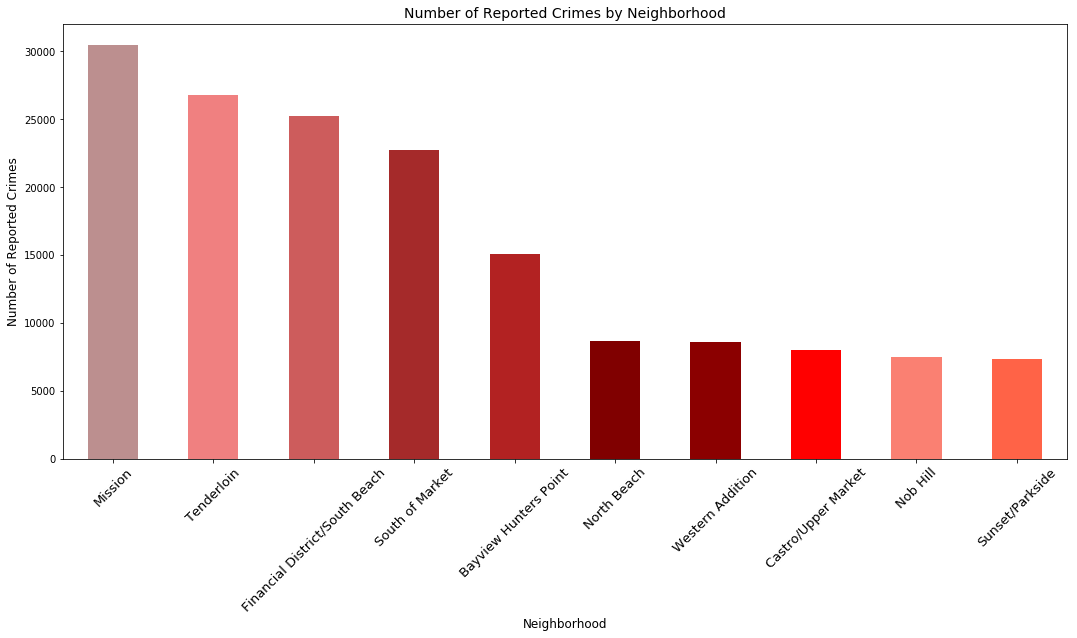

In [11]:

crime7.plot.bar(x = 'Neighborhood', y = 'Incidents', title = "Crime Incidents by Neighborhood", legend = None, rot= 45, figsize = (18, 8), color=['rosybrown', 'lightcoral', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'salmon', 'tomato'])
plt.ylabel('Number of Reported Crimes', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.title('Number of Reported Crimes by Neighborhood', fontsize = 14)
plt.show()

It looks like there are 5 spots with heavy crime rates in San Francisco, and the rest seem on par with eachother.

Let's take our 10 favorite neighborhoods from before and sort out these 5 Neighborhoods with the highest crime rate.

In [12]:
#get a dataframe with the 5 highest incident neighborhoods
crime8 = crime7.head(5)
crime8

Neighborhood  Incidents
18                         Mission      30502
35                      Tenderloin      26779
5   Financial District/South Beach      25276
33                 South of Market      22722
0            Bayview Hunters Point      15054

In [13]:
'''start by merging the datasets and making a new dataset that incldues the neighborhoods 
which wereamong the top 10 for businesses AND are amond the top 5 for crime '''
Overlap = business6.merge(crime8, on=['Neighborhood'])
'''then take this joined dataframe and remove all common values from your list of top 10 
neighborhoods for businesses'''
SF_Neighborhoods = business6[(~business6.Neighborhood.isin(Overlap.Neighborhood))]
'''and what you have is the top neighborhoods for businesses that are NOT the top 
neighborhoods for crime'''
SF_Neighborhoods.head()

Neighborhood  Businesses
34      Sunset/Parkside        4077
25       Outer Richmond        2736
16               Marina        2530
2   Castro/Upper Market        2483
39   West of Twin Peaks        2354

Now let's get the coordinates of each of our selected neighborhoods.

In [14]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_explorer")
SF_Neighborhoods['Coordinates'] = SF_Neighborhoods['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
SF_Neighborhoods

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Neighborhood  Businesses                       Coordinates
34      Sunset/Parkside        4077  (34.77319885, -82.3238098061844)
25       Outer Richmond        2736           (44.108805, -69.798725)
16               Marina        2530   (36.6900785, -121.800639830262)
2   Castro/Upper Market        2483        (-34.6274246, -58.4199519)
39   West of Twin Peaks        2354        (34.2388955, -117.2336533)
9          Hayes Valley        2351        (37.7766853, -122.4229361)

Yikes, looks like geopy had them all over the place. Marina and Hayes Valley seem to be right, but let's plug in values from Google Maps for the rest and clean up the coordinates a little.

In [15]:
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Sunset/Parkside' , 'Coordinates'] = "(37.751616, -122.490810)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Outer Richmond' , 'Coordinates'] = "(37.780001, -122.490229)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Castro/Upper Market' , 'Coordinates'] = "(37.762932, -122.435395)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'West of Twin Peaks' , 'Coordinates'] = "(37.739871, -122.460106)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Marina' , 'Coordinates'] = "(37.801406, -122.439718)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Hayes Valley' , 'Coordinates'] = "(37.776685, -122.422936)"
SF_Neighborhoods

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Neighborhood  Businesses               Coordinates
34      Sunset/Parkside        4077  (37.751616, -122.490810)
25       Outer Richmond        2736  (37.780001, -122.490229)
16               Marina        2530  (37.801406, -122.439718)
2   Castro/Upper Market        2483  (37.762932, -122.435395)
39   West of Twin Peaks        2354  (37.739871, -122.460106)
9          Hayes Valley        2351  (37.776685, -122.422936)

### Merging Datasets

Now, we can add the Latitude and Longitude in separate columns and merge our datasets

In [16]:
SF = SF_Neighborhoods.merge(crime6, on=['Neighborhood'])
SF.rename(columns={'Incidents':'Crimes'}, inplace = True)
SF = SF[['Neighborhood', 'Businesses', 'Crimes','Coordinates']]
SF['Coordinates'].to_string()
SF[['Latitude','Longitude']] = SF['Coordinates'].str.strip('(').str.strip(')').str.split(', ', expand=True)

SF

Neighborhood  Businesses  Crimes               Coordinates  \
0      Sunset/Parkside        4077    7344  (37.751616, -122.490810)   
1       Outer Richmond        2736    5657  (37.780001, -122.490229)   
2               Marina        2530    6205  (37.801406, -122.439718)   
3  Castro/Upper Market        2483    7994  (37.762932, -122.435395)   
4   West of Twin Peaks        2354    5106  (37.739871, -122.460106)   
5         Hayes Valley        2351    7164  (37.776685, -122.422936)   

    Latitude    Longitude  
0  37.751616  -122.490810  
1  37.780001  -122.490229  
2  37.801406  -122.439718  
3  37.762932  -122.435395  
4  37.739871  -122.460106  
5  37.776685  -122.422936

### Foursquare Data Analysis

Let's write a function to search the most popular venues within a .5 mile radius of our neighborhoods.

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
SF_venues = getNearbyVenues(names=SF['Neighborhood'],
                                   latitudes=SF['Latitude'],
                                   longitudes=SF['Longitude']
                                  )

Sunset/Parkside
Outer Richmond
Marina
Castro/Upper Market
West of Twin Peaks
Hayes Valley


In [19]:
#Le'ts see the shape of our dataframe
print(SF_venues.shape)
SF_venues.head()

(180, 7)


Neighborhood Neighborhood Latitude Neighborhood Longitude  \
0  Sunset/Parkside             37.751616            -122.490810   
1  Sunset/Parkside             37.751616            -122.490810   
2  Sunset/Parkside             37.751616            -122.490810   
3  Sunset/Parkside             37.751616            -122.490810   
4  Sunset/Parkside             37.751616            -122.490810   

                                    Venue  Venue Latitude  Venue Longitude  \
0                   S&T Hong Kong Seafood       37.753702      -122.491278   
1       Quan Ngon Vietnamese Noodle House       37.753624      -122.490549   
2  TJ Brewed Tea and Real Fruit (TJ Cups)       37.753561      -122.490028   
3                              Donut Time       37.753651      -122.489439   
4                     Polly Ann Ice Cream       37.753454      -122.497765   

          Venue Category  
0     Dim Sum Restaurant  
1  Vietnamese Restaurant  
2        Bubble Tea Shop  
3             Donut Shop  
4         Ice Cream Shop

In [20]:
#take a look at how many venues were pulled for each neighborhood
SF_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                
Castro/Upper Market                     30                      30     30   
Hayes Valley                            30                      30     30   
Marina                                  30                      30     30   
Outer Richmond                          30                      30     30   
Sunset/Parkside                         30                      30     30   
West of Twin Peaks                      30                      30     30   

                     Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                          
Castro/Upper Market              30               30              30  
Hayes Valley                     30               30              30  
Marina                           30               30              30  
Outer Richmond                   30               30              30  
Sunset/Parkside                  30               30              30  
West of Twin Peaks               30               30              30

In [21]:
#the number of unique types of venues pulled
print('There are {} uniques categories.'.format(len(SF_venues['Venue Category'].unique())))

There are 97 uniques categories.


what are the most common venue categories in our 6 selected neighborhoods?

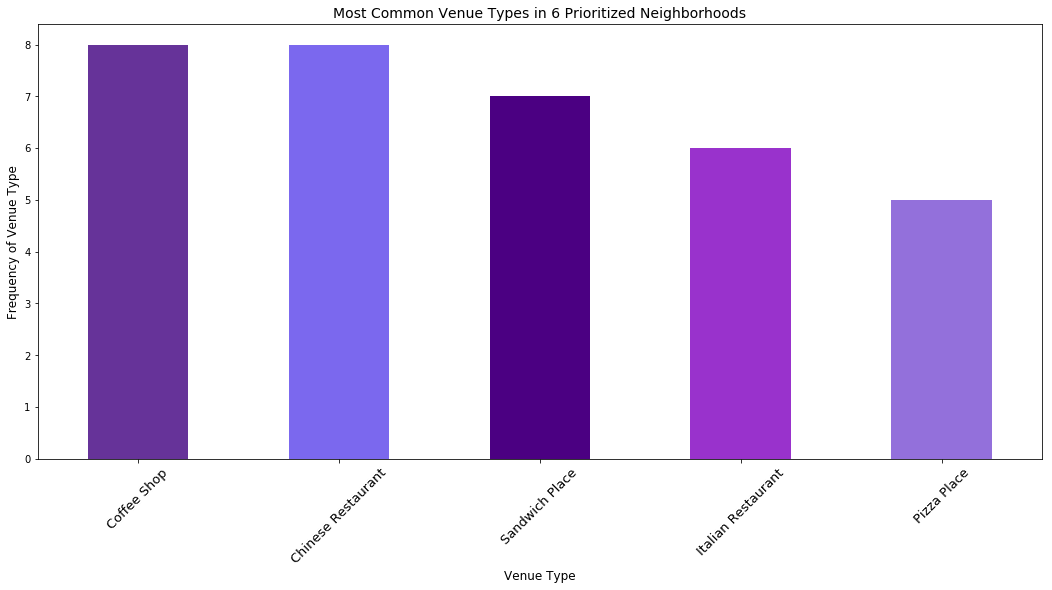

In [22]:
SF_top_venues = SF_venues.groupby('Venue Category', as_index = False).count().sort_values('Neighborhood', ascending = False).head(5)
SF_top_venues = SF_top_venues[['Venue Category','Neighborhood']]
SF_top_venues.rename(columns={'Neighborhood': 'Frequency'}, inplace = True)
SF_top_venues.plot.bar(x='Venue Category', y='Frequency', legend = None, title = "Most common venue types in 6 prioritized neighborhoods", rot= 45, figsize = (18, 8), color=['rebeccapurple','mediumslateblue','indigo','darkorchid','mediumpurple'])
plt.ylabel('Frequency of Venue Type', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Venue Type', fontsize=12)
plt.title('Most Common Venue Types in 6 Prioritized Neighborhoods', fontsize = 14)
plt.show()

It looks like coffee shops are the most common venue type, followed by some restaurants, and finally wine bars.

Let's do some one hot encoding to further analyze our results.

In [23]:
# one hot encoding
SF_onehot = pd.get_dummies(SF_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SF_onehot['Neighborhood'] = SF_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [SF_onehot.columns[-1]] + list(SF_onehot.columns[:-1])
SF_onehot = SF_onehot[fixed_columns]

SF_onehot.head()

Neighborhood  American Restaurant  Antique Shop  Arts & Crafts Store  \
0  Sunset/Parkside                    0             0                    0   
1  Sunset/Parkside                    0             0                    0   
2  Sunset/Parkside                    0             0                    0   
3  Sunset/Parkside                    0             0                    0   
4  Sunset/Parkside                    0             0                    0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Beer Garden  Bookstore  \
0           0       0     0    0               0            0          0   
1           0       0     0    0               0            0          0   
2           0       0     0    0               0            0          0   
3           0       0     0    0               0            0          0   
4           0       0     0    0               0            0          0   

   Boutique  Brazilian Restaurant  Brewery  Bubble Tea Shop  Burger Joint  \
0         0                     0        0                0             0   
1         0                     0        0                0             0   
2         0                     0        0                1             0   
3         0                     0        0                0             0   
4         0                     0        0                0             0   

   Burmese Restaurant  Burrito Place  Butcher  Café  Candy Store  \
0                   0              0        0     0            0   
1                   0              0        0     0            0   
2                   0              0        0     0            0   
3                   0              0        0     0            0   
4                   0              0        0     0            0   

   Cantonese Restaurant  Chinese Restaurant  Clothing Store  Cocktail Bar  \
0                     0                   0               0             0   
1                     0                   0               0             0   
2                     0                   0               0             0   
3                     0                   0               0             0   
4                     0                   0               0             0   

   Coffee Shop  Cosmetics Shop  Cupcake Shop  Cycle Studio  Deli / Bodega  \
0            0               0             0             0              0   
1            0               0             0             0              0   
2            0               0             0             0              0   
3            0               0             0             0              0   
4            0               0             0             0              0   

   Dessert Shop  Dim Sum Restaurant  Diner  Donut Shop  Electronics Store  \
0             0                   1      0           0                  0   
1             0                   0      0           0                  0   
2             0                   0      0           0                  0   
3             0                   0      0           1                  0   
4             0                   0      0           0                  0   

   Elementary School  Event Space  Field  Flower Shop  French Restaurant  \
0                  0            0      0            0                  0   
1                  0            0      0            0                  0   
2                  0            0      0            0                  0   
3                  0            0      0            0                  0   
4                  0            0      0            0                  0   

   Frozen Yogurt Shop  Furniture / Home Store  Gastropub  Greek Restaurant  \
0                   0                       0          0                 0   
1                   0                       0          0                 0   
2                   0                       0          0                 0   
3                   0                       0     

In [24]:
#examine shape of new dataframe
SF_onehot.shape

(180, 98)

In [25]:
#now group the data
SF_grouped = SF_onehot.groupby('Neighborhood').mean().reset_index()
print(SF_grouped.shape)
SF_grouped

(6, 98)


Neighborhood  American Restaurant  Antique Shop  \
0  Castro/Upper Market             0.000000      0.000000   
1         Hayes Valley             0.000000      0.000000   
2               Marina             0.033333      0.000000   
3       Outer Richmond             0.000000      0.033333   
4      Sunset/Parkside             0.000000      0.000000   
5   West of Twin Peaks             0.000000      0.000000   

   Arts & Crafts Store  Bagel Shop    Bakery      Bank       Bar  \
0             0.000000    0.000000  0.033333  0.000000  0.000000   
1             0.000000    0.033333  0.000000  0.000000  0.000000   
2             0.033333    0.000000  0.000000  0.000000  0.000000   
3             0.000000    0.000000  0.000000  0.000000  0.000000   
4             0.000000    0.000000  0.000000  0.033333  0.033333   
5             0.000000    0.000000  0.033333  0.000000  0.033333   

   Baseball Field  Beer Garden  Bookstore  Boutique  Brazilian Restaurant  \
0        0.000000     0.000000   0.033333  0.000000              0.000000   
1        0.000000     0.033333   0.000000  0.033333              0.000000   
2        0.000000     0.000000   0.033333  0.000000              0.000000   
3        0.000000     0.000000   0.000000  0.000000              0.000000   
4        0.033333     0.000000   0.000000  0.000000              0.000000   
5        0.000000     0.000000   0.033333  0.000000              0.033333   

    Brewery  Bubble Tea Shop  Burger Joint  Burmese Restaurant  Burrito Place  \
0  0.000000         0.000000      0.033333            0.000000       0.000000   
1  0.000000         0.000000      0.000000            0.000000       0.000000   
2  0.000000         0.000000      0.033333            0.000000       0.000000   
3  0.000000         0.000000      0.000000            0.033333       0.033333   
4  0.033333         0.033333      0.000000            0.000000       0.000000   
5  0.000000         0.000000      0.033333            0.000000       0.000000   

    Butcher      Café  Candy Store  Cantonese Restaurant  Chinese Restaurant  \
0  0.000000  0.000000     0.033333              0.000000            0.000000   
1  0.033333  0.000000     0.000000              0.000000            0.000000   
2  0.000000  0.000000     0.000000              0.000000            0.033333   
3  0.000000  0.100000     0.000000              0.000000            0.066667   
4  0.000000  0.000000     0.000000              0.033333            0.133333   
5  0.000000  0.033333     0.033333              0.000000            0.033333   

   Clothing Store  Cocktail Bar  Coffee Shop  Cosmetics Shop  Cupcake Shop  \
0        0.033333      0.000000     0.100000        0.000000      0.000000   
1        0.000000      0.066667     0.066667        0.000000      0.000000   
2        0.033333      0.000000     0.000000        0.033333      0.033333   
3        0.000000      0.000000     0.033333        0.033333      0.000000   
4        0.000000      0.000000     0.033333        0.000000      0.000000   
5        0.000000      0.000000     0.033333        0.000000      0.000000   

   Cycle Studio  Deli / Bodega  Dessert Shop  Dim Sum Restaurant     Diner  \
0      0.033333       0.033333      0.000000            0.000000  0.000000   
1      0.000000       0.000000      0.000000            0.000000  0.000000   
2      0.000000       0.066667      0.000000            0.000000  0.033333   
3      0.000000       0.033333      0.000000            0.000000  0.000000   
4      0.000000       0.000000      0.033333            0.066667  0.000000   
5      0.000000       0.000000      0.000000            0.000000  0.033333   

   Donut Shop  Electronics Store  Elementary School  Event Space     Field  \
0    0.000000           0.000000           0.000000     0.000000  0.000000   
1    0.000000           0.000000           0.000000     0.033333  0.000000   
2    0.000000           0.033333           0.000000     0.000000  0.000000   
3    0.000000           0.0000

We can now see the frequency of the top 5 types of venues for each neighborhood.

In [26]:
#print each neighborhood with the top 5 most common venues
num_top_venues = 5

for hood in SF_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = SF_grouped[SF_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Castro/Upper Market----
                     venue  freq
0              Coffee Shop  0.10
1  New American Restaurant  0.07
2              Candy Store  0.03
3           Clothing Store  0.03
4             Cycle Studio  0.03


----Hayes Valley----
               venue  freq
0  French Restaurant  0.10
1           Wine Bar  0.07
2        Coffee Shop  0.07
3       Cocktail Bar  0.07
4        Yoga Studio  0.03


----Marina----
                  venue  freq
0    Italian Restaurant  0.07
1         Deli / Bodega  0.07
2     French Restaurant  0.07
3  Gym / Fitness Center  0.07
4   American Restaurant  0.03


----Outer Richmond----
                venue  freq
0                Café  0.10
1      Sandwich Place  0.07
2  Chinese Restaurant  0.07
3  Seafood Restaurant  0.07
4       Burrito Place  0.03


----Sunset/Parkside----
                 venue  freq
0   Chinese Restaurant  0.13
1           Playground  0.07
2  Japanese Restaurant  0.07
3   Dim Sum Restaurant  0.07
4       Ice Cream Shop  0.03

Now we can place our data into a dataframe of the most popular venues for each neighborhood.

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = SF_grouped['Neighborhood']

for ind in np.arange(SF_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SF_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue    2nd Most Common Venue  \
0  Castro/Upper Market           Coffee Shop  New American Restaurant   
1         Hayes Valley     French Restaurant              Coffee Shop   
2               Marina         Deli / Bodega       Italian Restaurant   
3       Outer Richmond                  Café       Chinese Restaurant   
4      Sunset/Parkside    Chinese Restaurant       Dim Sum Restaurant   
5   West of Twin Peaks                  Park           Sandwich Place   

  3rd Most Common Venue 4th Most Common Venue     5th Most Common Venue  \
0           Yoga Studio    Salon / Barbershop  Mediterranean Restaurant   
1              Wine Bar          Cocktail Bar               Yoga Studio   
2  Gym / Fitness Center     French Restaurant                     Diner   
3        Sandwich Place    Seafood Restaurant                Restaurant   
4            Playground   Japanese Restaurant      Cantonese Restaurant   
5    Italian Restaurant          Burger Joint                       Pub   

  6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0        Clothing Store           Liquor Store           Candy Store   
1           Pizza Place  Performing Arts Venue      Pedestrian Plaza   
2   Japanese Restaurant       Greek Restaurant             Gastropub   
3   Japanese Restaurant             Playground           Pizza Place   
4     Elementary School            Music Venue          Optical Shop   
5              Pharmacy                   Café           Candy Store   

    9th Most Common Venue   10th Most Common Venue 11th Most Common Venue  \
0           Jewelry Store              Pizza Place           Burger Joint   
1  Furniture / Home Store  New American Restaurant           Liquor Store   
2       Electronics Store        Hotpot Restaurant            Pizza Place   
3      Italian Restaurant            Burrito Place     Burmese Restaurant   
4            Dessert Shop                 Pharmacy            Pizza Place   
5      Frozen Yogurt Shop        Indian Restaurant     Chinese Restaurant   

  12th Most Common Venue   13th Most Common Venue 14th Most Common Venue  \
0             Public Art      Indie Movie Theater           Cycle Studio   
1            Men's Store         Ramen Restaurant              Jazz Club   
2           Cupcake Shop           Cosmetics Shop         Clothing Store   
3            Coffee Shop  New American Restaurant      Korean Restaurant   
4             Donut Shop            Middle School                Brewery   
5             Nail Salon            Movie Theater    Monument / Landmark   

  15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
0         Ice Cream Shop         Sandwich Place          Historic Site   
1     Italian Restaurant         Ice Cream Shop              Wine Shop   
2     Chinese Restaurant           Burger Joint              Bookstore   
3          Movie Theater         Cosmetics Shop          Deli / Bodega   
4        Bubble Tea Shop         Sandwich Place         Baseball Field   
5            Coffee Shop     Mexican Restaurant                  Diner   

     18th Most Common Venue 19th Most Common Venue 20th Most Common Venue  \
0                  Wine Bar            Flower Shop                 Bakery   
1               Event Space                Butcher           Optical Shop   
2       Arts & Crafts Store           Noodle House    American Restaurant   
3        Mexican Restaurant     Russian Restaurant       Sushi Restaurant   
4     Vietnamese Restaurant                   Bank                    Bar   
5  Mediterranean Restaurant                 Bakery        Thai Restaurant   

  21th Most Common Venue 22th Most Common Venue 23th Most Common Venue  \
0                    Gym   Gym / Fitness Center          Deli / Bodega   
1       Sushi Restaurant          Souvlaki Shop            Beer Garden   
2        Thai Restaurant               Wine Bar            Salad Place   
3           Antique Shop               

### Clustering

Let's use K means clustering to cluster our neighborhoods for more insights!

In [29]:
# set number of clusters
kclusters = 3

SF_grouped_clustering = SF_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SF_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 1, 0, 1], dtype=int32)

Now create a dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

SF_merged = SF

In [31]:
# merge SF_grouped with SF_data to add latitude/longitude for each neighborhood
SF_merged = SF_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [32]:
#also including the number of bars and restaurants that each neighborhood has in its top 10 most popular spots.
SF_merged["Bars and Restaurants"] = ""
SF_merged.loc[SF_merged.Neighborhood == 'Sunset/Parkside', 'Bars and Restaurants'] = .37
SF_merged.loc[SF_merged.Neighborhood == 'Outer Richmond', 'Bars and Restaurants'] = .6
SF_merged.loc[SF_merged.Neighborhood == 'Marina', 'Bars and Restaurants'] = .67
SF_merged.loc[SF_merged.Neighborhood == 'Castro/Upper Market', 'Bars and Restaurants'] = .37
SF_merged.loc[SF_merged.Neighborhood == 'West of Twin Peaks', 'Bars and Restaurants'] = .5
SF_merged.loc[SF_merged.Neighborhood == 'Hayes Valley', 'Bars and Restaurants'] = .5
SF_merged['Bars and Restaurants'].astype(int, inplace = True)

0    0
1    0
2    0
3    0
4    0
5    0
Name: Bars and Restaurants, dtype: int64

In [33]:
SF_merged['Latitude'] = SF_merged['Latitude'].astype(float)
SF_merged['Longitude'] = SF_merged['Longitude'].astype(float)
SF_merged['Cluster Labels'] = SF_merged['Cluster Labels'].astype(int)



SF_merged 

Neighborhood  Businesses  Crimes               Coordinates  \
0      Sunset/Parkside        4077    7344  (37.751616, -122.490810)   
1       Outer Richmond        2736    5657  (37.780001, -122.490229)   
2               Marina        2530    6205  (37.801406, -122.439718)   
3  Castro/Upper Market        2483    7994  (37.762932, -122.435395)   
4   West of Twin Peaks        2354    5106  (37.739871, -122.460106)   
5         Hayes Valley        2351    7164  (37.776685, -122.422936)   

    Latitude   Longitude  Cluster Labels 1st Most Common Venue  \
0  37.751616 -122.490810               0    Chinese Restaurant   
1  37.780001 -122.490229               1                  Café   
2  37.801406 -122.439718               1         Deli / Bodega   
3  37.762932 -122.435395               2           Coffee Shop   
4  37.739871 -122.460106               1                  Park   
5  37.776685 -122.422936               2     French Restaurant   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0       Dim Sum Restaurant            Playground   Japanese Restaurant   
1       Chinese Restaurant        Sandwich Place    Seafood Restaurant   
2       Italian Restaurant  Gym / Fitness Center     French Restaurant   
3  New American Restaurant           Yoga Studio    Salon / Barbershop   
4           Sandwich Place    Italian Restaurant          Burger Joint   
5              Coffee Shop              Wine Bar          Cocktail Bar   

      5th Most Common Venue 6th Most Common Venue  7th Most Common Venue  \
0      Cantonese Restaurant     Elementary School            Music Venue   
1                Restaurant   Japanese Restaurant             Playground   
2                     Diner   Japanese Restaurant       Greek Restaurant   
3  Mediterranean Restaurant        Clothing Store           Liquor Store   
4                       Pub              Pharmacy                   Café   
5               Yoga Studio           Pizza Place  Performing Arts Venue   

  8th Most Common Venue   9th Most Common Venue   10th Most Common Venue  \
0          Optical Shop            Dessert Shop                 Pharmacy   
1           Pizza Place      Italian Restaurant            Burrito Place   
2             Gastropub       Electronics Store        Hotpot Restaurant   
3           Candy Store           Jewelry Store              Pizza Place   
4           Candy Store      Frozen Yogurt Shop        Indian Restaurant   
5      Pedestrian Plaza  Furniture / Home Store  New American Restaurant   

  11th Most Common Venue 12th Most Common Venue   13th Most Common Venue  \
0            Pizza Place             Donut Shop            Middle School   
1     Burmese Restaurant            Coffee Shop  New American Restaurant   
2            Pizza Place           Cupcake Shop           Cosmetics Shop   
3           Burger Joint             Public Art      Indie Movie Theater   
4     Chinese Restaurant             Nail Salon            Movie Theater   
5           Liquor Store            Men's Store         Ramen Restaurant   

  14th Most Common Venue 15th Most Common Venue 16th Most Common Venue  \
0                Brewery        Bubble Tea Shop         Sandwich Place   
1      Korean Restaurant          Movie Theater         Cosmetics Shop   
2         Clothing Store     Chinese Restaurant           Burger Joint   
3           Cycle Studio         Ice Cream Shop         Sandwich Place   
4    Monument / Landmark            Coffee Shop     Mexican Restaurant   
5              Jazz Club     Italian Restaurant         Ice Cream Shop   

  17th Most Common Venue    18th Most Common Venue 19th Most Common Venue  \
0         Baseball Field     Vietnamese Restaurant                   Bank   
1          Deli / Bodega        Mexican Restaurant     Russian Restaurant   
2              Bookstore       Arts & Crafts Store           Noodle House   
3          Historic Site                  Wine Bar            Flower Shop   
4                  D

Let's visualize the percentage of pupular venues in each neighborhood that are bars or restaurants. this will help us see which neighborhoods are more popular BECAUSE of their bar and restuaraunt scene, and which are popular for other reasons.

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


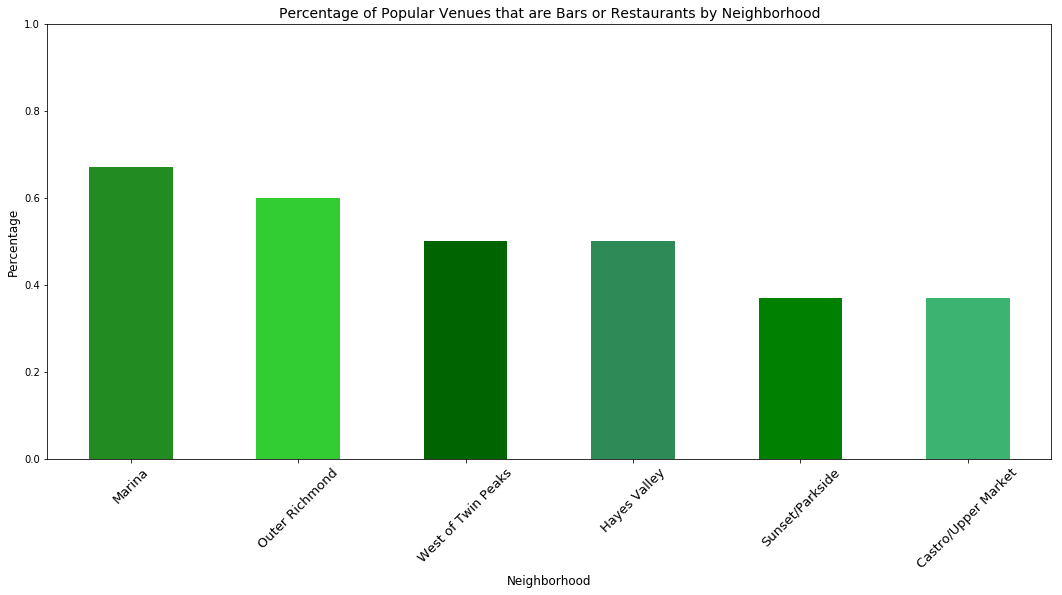

In [34]:
SF_rb = SF_merged[['Neighborhood','Bars and Restaurants']]
SF_rb.rename(columns={'Bars and Restaurants': 'Frequency'}, inplace = True)
SF_rb.sort_values('Frequency', inplace = True, ascending = False)
SF_rb.plot.bar(x='Neighborhood',y ='Frequency', rot = 45, figsize = (18, 8), legend = None, color = ['forestgreen','limegreen','darkgreen','seagreen','green','mediumseagreen'])
plt.ylabel('Percentage', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylim(0,1)
plt.title('Percentage of Popular Venues that are Bars or Restaurants by Neighborhood', fontsize = 14)
plt.show()

### Map Clustered Neighborhoods

Next, let's pull the coordinates for San Francisco and build a map.

In [35]:
address = 'San Francisco, California'

geolocator = Nominatim(user_agent="SF_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7792808, -122.4192363.


Finally, let's map our clustered neighborhoods to see which ones are more similar.

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(.7, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add markers to the map
markers_colors = []
for lat, lon, poi, cluster, bars in zip(SF_merged['Latitude'], SF_merged['Longitude'], SF_merged['Neighborhood'], SF_merged['Cluster Labels'], SF_merged['Bars and Restaurants']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=35*bars,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters